In [ ]:
import kagglehub
tthien_shanghaitech_path = kagglehub.dataset_download('tthien/shanghaitech')

print('Data source import complete.')


Data source import complete.


In [ ]:
#GENERAL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

#PATH PROCESS
import os
from pathlib import Path
import glob
from scipy.io import loadmat

# image processing
import cv2
from scipy.ndimage import gaussian_filter

# Neural Network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision

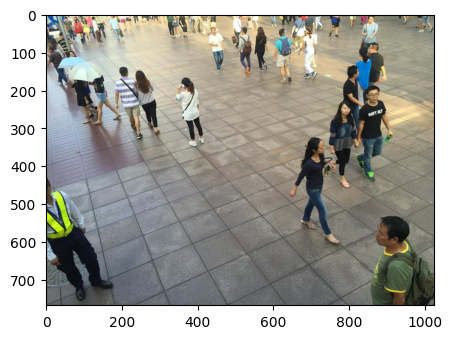

In [ ]:
# ---------------------------------------------
# 1) 이미지 파일 경로 지정
#    └ 노트북에 미리 마운트된 ShanghaiTech Part B 학습용 이미지 중 하나
# ---------------------------------------------
path_img_ex = '/kaggle/input/shanghaitech/ShanghaiTech/part_B/train_data/images/IMG_6.jpg'

# ---------------------------------------------
# 2) OpenCV로 이미지 읽기( BGR 순서 ) → RGB 순서로 변환
#    ───────────────────────────────────────────
#    · cv2.imread()  : 파일에서 이미지를 BGR 색상으로 불러옵니다.
#    · cv2.cvtColor(): 색상 순서를 BGR ➜ RGB 로 바꿔
#                     matplotlib 에 올바르게 표시되도록 합니다.
# ---------------------------------------------
image_ex = cv2.cvtColor(cv2.imread(path_img_ex), cv2.COLOR_BGR2RGB)

# ---------------------------------------------
# 3) matplotlib Figure 객체 생성
#    └ figsize=(5,5) 는 5×5 인치 크기의 그림 캔버스를 의미합니다.
# ---------------------------------------------
figure = plt.figure(figsize=(5, 5))

# ---------------------------------------------
# 4) 이미지 렌더링
#    └ plt.imshow() 는 넘파이 배열(RGB) 을 화면에 그립니다.
# ---------------------------------------------
plt.imshow(image_ex)

# ---------------------------------------------
# 5) 실제로 화면(또는 노트북 셀) 에 출력
#    └ plt.show() 를 호출해야 이미지가 보입니다.
# ---------------------------------------------
plt.show()


In [ ]:
# --------------------------------------------------------------
# 1) 학습용 Ground-Truth(정답) 파일 경로 지정
#    ────────────────────────────────────────────────────────────
#    · ShanghaiTech Part B ─ train_data ─ ground-truth 폴더 안에
#      ‘GT_IMG_6.mat’이라는 MATLAB 포맷(.mat) 파일이 있습니다.
#    · .mat 파일에는 이미지에 표시된 ‘사람 머리 위치’ 좌표가
#      (x, y) 배열 형태로 들어 있습니다.
# --------------------------------------------------------------
path_gt_ex = "/kaggle/input/shanghaitech/ShanghaiTech/part_B/train_data/ground-truth/GT_IMG_6.mat"

# --------------------------------------------------------------
# 2) scipy.io.loadmat() 로 .mat 파일 읽기
#    ────────────────────────────────────────────────────────────
#    · loadmat() 는 MATLAB에서 저장한 구조체/배열을
#      Python 딕셔너리 형태로 변환해 주는 함수입니다.
#    · 키(key) 는 MATLAB 변수 이름,
#      값(value) 는 넘파이 배열 또는 중첩 dict 로 매핑됩니다.
# --------------------------------------------------------------
gt_ex = loadmat(path_gt_ex)

# --------------------------------------------------------------
# 3) 타입과 내부 키 목록 확인
#    ────────────────────────────────────────────────────────────
#    · 타입(type)  : scipy.io.matlab._mio5.MatlabFile 의 dict 변형
#                    (표준 dict와 거의 동일하게 동작)
#    · items()     : (key, value) 쌍 전체를 튜플 리스트로 반환
#    · 이 단계에서 어떤 이름·구조로 데이터가
#      저장돼 있는지 빠르게 파악할 수 있습니다.
# --------------------------------------------------------------
print('type: ', type(gt_ex))
print(gt_ex.items())


type:  <class 'dict'>
dict_items([('__header__', b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri Nov 18 19:55:34 2016'), ('__version__', '1.0'), ('__globals__', []), ('image_info', array([[array([[(array([[  3.94945534, 469.96427015],
                       [919.86056645, 584.69019608],
                       [722.64575163, 353.34204793],
                       [794.70501089, 254.73464052],
                       [866.76427015, 219.65315904],
                       [815.56427015, 156.12723312],
                       [371.83093682, 180.77908497],
                       [251.416122  , 168.45315904],
                       [204.95686275, 154.23093682],
                       [ 12.48278867,  92.36427015],
                       [ 20.54204793,  71.50501089],
                       [ 70.31982571, 107.53464052],
                       [ 43.53464052,  59.06056645],
                       [ 84.18649237,  18.26056645],
                       [100.83834423,  16.18649237],
             

In [ ]:
# --------------------------------------------------------------
# 1) .mat 파일(=gt_ex)에 어떤 변수(키)가 들어 있는지 확인
#    ────────────────────────────────────────────────────────────
#    ▶ MATLAB에서 저장한 구조체/배열은 Python 딕셔너리 형태로
#      로드되므로, .keys() 로 최상위 변수 이름을 살펴볼 수 있습니다.
#    ▶ ShanghaiTech GT 파일에는 보통 'image_info' 라는 키 하나만
#      들어 있습니다.
# --------------------------------------------------------------
print(gt_ex.keys())          # dict_keys(['__header__', '__version__', '__globals__', 'image_info'])

dict_keys(['__header__', '__version__', '__globals__', 'image_info'])


In [ ]:
# --------------------------------------------------------------
# 2) 머리 좌표 (x, y) 배열 꺼내기
#    ────────────────────────────────────────────────────────────
#    (※ MATLAB 구조체가 5-중첩 배열로 포장돼 있기 때문에
#       인덱스를 다섯 번 [0] 으로 풀어줘야 실제 넘파이 배열에 닿습니다.)
#
#    이미지 한 장에 대해:
#      gt_ex['image_info']        → 크기 (1,1) 2-차원 배열
#      [0][0]                    → “구조체(struct)” 내부로 진입
#      [0]                       → 'location' 필드 (좌표) 등 여러 요소 중 첫 번째
#      [0]                       → 사람 좌표 배열이 들어 있는 리스트
#      [0]                       → 실제 (N,2) shape 의 넘파이 배열
# --------------------------------------------------------------
gt_coor_ex = gt_ex.get('image_info')[0][0][0][0][0]

# --------------------------------------------------------------
# 3) 좌표 배열 크기 확인
#    ────────────────────────────────────────────────────────────
#    · shape = (N, 2)
#      N  : 이미지 안에 어노테이션된 사람(머리) 수
#      2  : 각 사람의 x, y 좌표
# --------------------------------------------------------------
print('Shape of coordinates:', gt_coor_ex.shape)   # 예) (97, 2)

# 필요하면 실제 좌표 값을 보고 싶을 때는 주석 풀어서 사용
# print(gt_coor_ex)

Shape of coordinates: (36, 2)


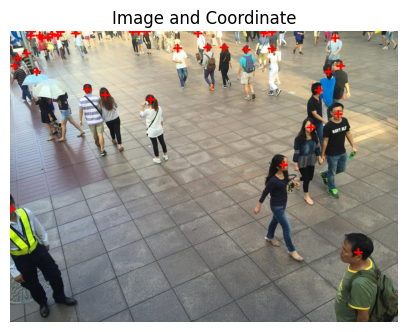

In [ ]:
# ---------------------------------------------
# 1) 새 Figure(그림 창) 생성
#    └ figsize=(5,5)는 가로×세로 5×5인치 크기의 캔버스 설정
# ---------------------------------------------
figure = plt.figure(figsize=(5, 5))

# ---------------------------------------------
# 2) 어노테이션 좌표마다 반복하며 이미지 위에 마커 표시
# ---------------------------------------------
for x_cor, y_cor in gt_coor_ex:
    # · x_cor, y_cor: gt_coor_ex 배열에서 꺼낸 한 사람의 (x, y) 좌표
    # · int(): 좌표가 실수일 수 있으니 정수 픽셀 위치로 변환
    # · (255, 0, 0): BGR 색상으로 파란색 마커를 그리지만,
    #                RGB로 변환된 이미지에는 빨간색으로 보일 수 있음
    # · thickness=3: 마커 선 두께 지정
    cv2.drawMarker(
        image_ex,                 # 마커를 그릴 대상 이미지 배열
        (int(x_cor), int(y_cor)), # 마커 중앙 위치 (x, y)
        (255, 0, 0),              # 마커 색상 (B, G, R)
        thickness=3               # 마커 선 굵기
    )

# ---------------------------------------------
# 3) Matplotlib로 이미지 출력
# ---------------------------------------------
plt.imshow(image_ex)               # RGB 순서 배열을 화면에 그리기
plt.title("Image and Coordinate")  # 그림 위에 제목 추가
plt.axis('off')                    # 축 눈금과 테두리 숨기기 (선택 사항)
plt.show()                         # 실제로 Jupyter 노트북 셀에 표시


In [ ]:
def gen_density_map_gaussian(image, coords, sigma=5):
    """
    이미지를 기반으로 사람 머리 좌표(coords)마다 Gaussian 분포를 더해
    부드러운 density map을 생성합니다.

    Parameters
    ----------
    image : np.ndarray
        원본 이미지 배열 (H, W, C) 또는 (H, W). 높이(H)와 너비(W) 정보만 사용.
    coords : array-like of shape (N, 2)
        사람 머리 위치 좌표 리스트. 각 원소는 (x, y) 픽셀 좌표.
    sigma : float, optional
        Gaussian 커널의 표준편차(반경), 기본값은 5.

    Returns
    -------
    density_map : np.ndarray of shape (H, W)
        Gaussian 분포가 누적된 density map. 전체 합은 coords 개수와 동일.
    """

    # 1) 이미지 크기(H, W)와 동일한 2D 배열을 만들고 0으로 초기화
    #    → 각 좌표 위치에 1을 찍어준 뒤 Gaussian 필터를 적용하기 위함
    img_zeros = np.zeros(image.shape[:2], dtype=np.float32)
    #    image.shape[:2]는 (높이, 너비) 튜플을 반환

    # 2) 사람 머리 위치마다 1을 표시
    #    → 이후 gaussian_filter가 이 1값을 부드럽게 분포시켜 density를 생성
    for x_cor, y_cor in coords:
        # 좌표가 실수일 수 있으니 int()로 픽셀 인덱스로 변환
        # 배열 인덱스는 [행, 열] = [y, x] 순서임에 유의
        img_zeros[int(y_cor), int(x_cor)] = 1

    # 3) Gaussian 필터 적용
    #    sigma    : 표준편차, 분포의 퍼진 정도를 조절
    #    truncate : 필터 크기를 sigma * truncate 기준으로 자름
    #               (기본값 4.0보다 넓게 5*5=25로 설정하여 꼬리까지 반영)
    density_map = gaussian_filter(img_zeros, sigma=sigma, truncate=5*5)

    # 4) 완성된 density map 반환
    #    → 이 맵의 모든 픽셀 값을 합하면 원래 사람 수와 동일
    return density_map


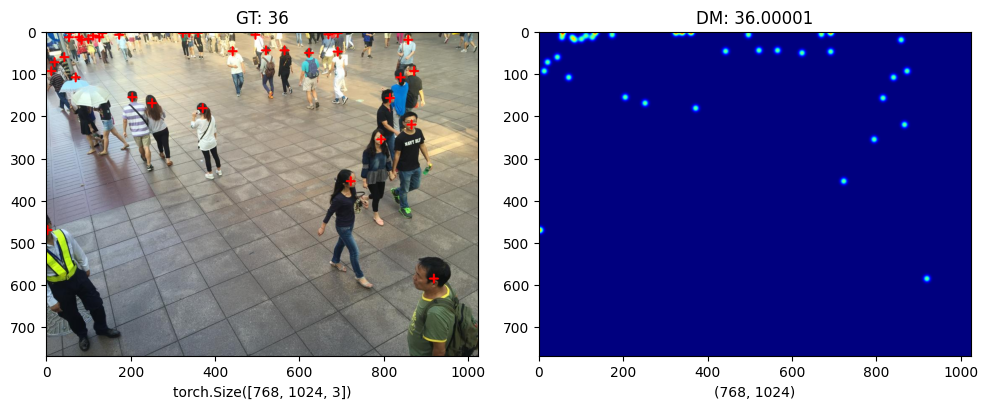

max1 : tensor(1.)
max2 : 0.012646893
min1 : tensor(0.)
min2 : 0.0


In [ ]:
# ────────────────────────────────────────────────────────────────
# 1) 밀도 맵 생성 호출
#    · gen_density_map_gaussian(): 앞서 정의한 함수로
#      image_ex (원본 이미지)와 gt_coor_ex (좌표 리스트)를 입력해
#      Gaussian density map 생성
#    · sigma=5: Gaussian 표준편차
# ────────────────────────────────────────────────────────────────
density_map_ex = gen_density_map_gaussian(image_ex, gt_coor_ex, sigma=5)

# ────────────────────────────────────────────────────────────────
# 2) 시각화 캔버스 준비
#    · figsize=(10,5): 가로 10인치 × 세로 5인치 크기 설정
# ────────────────────────────────────────────────────────────────
figure = plt.figure(figsize=(10, 5))

# ────────────────────────────────────────────────────────────────
# 3) 왼쪽 서브플롯: 원본 이미지
# ────────────────────────────────────────────────────────────────
plt.subplot(1, 2, 1)

# ────────────────────────────────────────────────────────────────
# 3-1) 이미지 정규화 & 텐서 변환
#     · image_ex / 255       : 0~255 사이 픽셀 값을 0~1 범위로 스케일링
#     · torch.tensor(...): PyTorch 텐서로 변환
#     · dtype=torch.float : 부동소수점 타입 지정
# ────────────────────────────────────────────────────────────────
image_ex = torch.tensor(image_ex / 255.0, dtype=torch.float)

# ────────────────────────────────────────────────────────────────
# 3-2) x축 레이블에 텐서 형상 표시
#     · image_ex.shape: (채널, 높이, 너비) 튜플 출력
# ────────────────────────────────────────────────────────────────
plt.xlabel(image_ex.shape)

# ────────────────────────────────────────────────────────────────
# 3-3) 제목: GT 인원수 표시
#     · gt_coor_ex.shape[0]: 좌표 배열 첫 차원 크기 = 사람 수
# ────────────────────────────────────────────────────────────────
plt.title('GT: ' + str(gt_coor_ex.shape[0]))

# ────────────────────────────────────────────────────────────────
# 3-4) 이미지 렌더링
#     · tensor → NumPy 변환 없이 matplotlib가 처리
#     · permute가 필요할 경우: image_ex.permute(1,2,0).numpy()
# ────────────────────────────────────────────────────────────────
plt.imshow(image_ex)

# ────────────────────────────────────────────────────────────────
# 4) 오른쪽 서브플롯: 생성된 Density Map
# ────────────────────────────────────────────────────────────────
plt.subplot(1, 2, 2)

# ────────────────────────────────────────────────────────────────
# 4-1) x축 레이블에 밀도 맵 형상 표시
#     · density_map_ex.shape: (높이, 너비)
# ────────────────────────────────────────────────────────────────
plt.xlabel(density_map_ex.shape)

# ────────────────────────────────────────────────────────────────
# 4-2) 제목: DM(밀도 맵) 합계 = 예측 인원수
#     · np.sum(density_map_ex): 밀도 맵 픽셀 값 합
# ────────────────────────────────────────────────────────────────
plt.title('DM: ' + str(np.sum(density_map_ex)))

# ────────────────────────────────────────────────────────────────
# 4-3) 밀도 맵 렌더링
#     · cmap="jet": 컬러맵 jet 적용해 높은 값 강조
# ────────────────────────────────────────────────────────────────
plt.imshow(density_map_ex, cmap="jet")

# ────────────────────────────────────────────────────────────────
# 5) 화면에 모든 서브플롯 출력
# ────────────────────────────────────────────────────────────────
plt.tight_layout()  # 서브플롯 간 여백 자동 조정
plt.show()

# ────────────────────────────────────────────────────────────────
# 6) 텐서·맵 값 범위 확인
#    · image_ex.max()/min(): 정규화된 이미지의 최대·최소 픽셀
#    · density_map_ex.max()/min(): density map의 최대·최소 값
# ────────────────────────────────────────────────────────────────
print('max1 :', image_ex.max())            # 이미지 픽셀 최대값 (1.0에 근접)
print('max2 :', density_map_ex.max())      # 밀도 맵에서 가장 높은 값 (가우시안 peak)
print('min1 :', image_ex.min())            # 이미지 픽셀 최소값 (0.0에 근접)
print('min2 :', density_map_ex.min())      # 밀도 맵 최소값 (0.0, 사람이 없는 영역)


In [ ]:
class DataLoader(Dataset):
    """
    ShanghaiTech 군중 카운팅용 PyTorch Dataset 클래스입니다.
    - images/ 폴더의 JPG 이미지와
      ground-truth/ 폴더의 .mat 정답 파일(.image_info)을 읽어오고,
    - 각 이미지마다 density map과 사람 수를 미리 생성·저장해
      __getitem__ 호출 시 빠르게 반환합니다.
    """

    def __init__(self, root_dir, gt_downsample=4, shuffle=False, target_size=(1024, 768)):
        # 1) 생성자 인자 저장
        #    root_dir      : 'images/'와 'ground-truth/' 폴더가 있는 최상위 디렉터리
        #    gt_downsample : density map 해상도를 축소할 배율 (예: 4 → 1/4 크기)
        #    shuffle       : True 면 매 호출 시마다 이미지 순서를 무작위로 섞음
        #    target_size   : (width, height) 형태로 모든 이미지를 리사이즈할 크기
        self.root_dir = root_dir
        self.gt_downsample = gt_downsample
        self.shuffle = shuffle
        self.target_size = target_size

        # 2) images 폴더 내의 .jpg 파일명 리스트 수집
        images_folder = os.path.join(root_dir, 'images')
        self.img_names = [
            fname for fname in os.listdir(images_folder)
            if fname.lower().endswith('.jpg')
        ]

        # 3) shuffle=True 면 파일 리스트 섞기
        if self.shuffle:
            random.shuffle(self.img_names)

        # 4) density map과 사람 수를 캐싱할 딕셔너리 준비
        self.DMs = {}       # {이미지경로: density_map_numpy배열}
        self.n_people = {}  # {이미지경로: 정수 사람 수}

        # 5) 각 이미지에 대해 미리 density map 생성
        for img_name in self.img_names:
            img_path = os.path.join(root_dir, 'images', img_name)
            gt_name = 'GT_' + img_name.split('.')[0] + '.mat'
            gt_path = os.path.join(root_dir, 'ground-truth', gt_name)

            coords = loadmat(gt_path)['image_info'][0][0][0][0][0]
            img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            dm = gen_density_map_gaussian(img, coords, sigma=5)

            self.DMs[img_path] = dm
            self.n_people[img_path] = coords.shape[0]

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, index):
        # 1) 경로들
        img_path = os.path.join(self.root_dir, 'images', self.img_names[index])
        gt_count = self.n_people[img_path]
        gt_map   = self.DMs[img_path]  # (H_orig, W_orig)

        # 2) 원본 이미지 로드 & RGB
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        # 3) 고정 크기로 리사이즈
        TW, TH = self.target_size
        img = cv2.resize(img, (TW, TH))
        dm_w, dm_h = TW // self.gt_downsample, TH // self.gt_downsample
        gt_map = cv2.resize(gt_map, (dm_w, dm_h)) * (self.gt_downsample ** 2)

        # 4) (H, W, C) → (C, H, W), 0~1 정규화
        img = img.transpose(2, 0, 1) / 255.0

        # 5) Tensor 변환
        img_tensor = torch.tensor(img, dtype=torch.float)
        dm_tensor  = torch.tensor(gt_map[np.newaxis], dtype=torch.float)

        return img_tensor, dm_tensor, gt_count


In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 1) 테스트 데이터셋 경로 설정 및 DataLoader 인스턴스 생성
#    - root_dir: 테스트 이미지와 정답(.mat) 파일이 들어 있는 폴더
#    - gt_downsample=4: density map 해상도를 원본의 1/4로 축소
#    - shuffle=True: 매번 호출 시 이미지 순서를 무작위로 섞어 반환
# ──────────────────────────────────────────────────────────────────────────────
#root_dir = "/kaggle/input/shanghaitech/ShanghaiTech/part_B/test_data/"
#dataset = DataLoader(root_dir, gt_downsample=4, shuffle=True)

from torch.utils.data import ConcatDataset

# Part A, Part B 테스트용 Dataset 생성
testA = DataLoader(
    root_dir="/kaggle/input/shanghaitech/ShanghaiTech/part_A/test_data/",
    gt_downsample=4,
    shuffle=False
)
testB = DataLoader(
    root_dir="/kaggle/input/shanghaitech/ShanghaiTech/part_B/test_data/",
    gt_downsample=4,
    shuffle=False
)

# 두 Dataset 합치기
full_test = ConcatDataset([testA, testB])

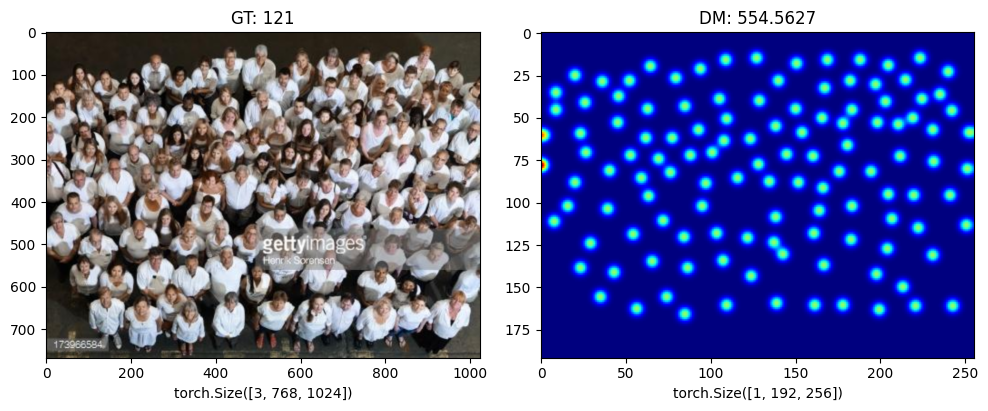

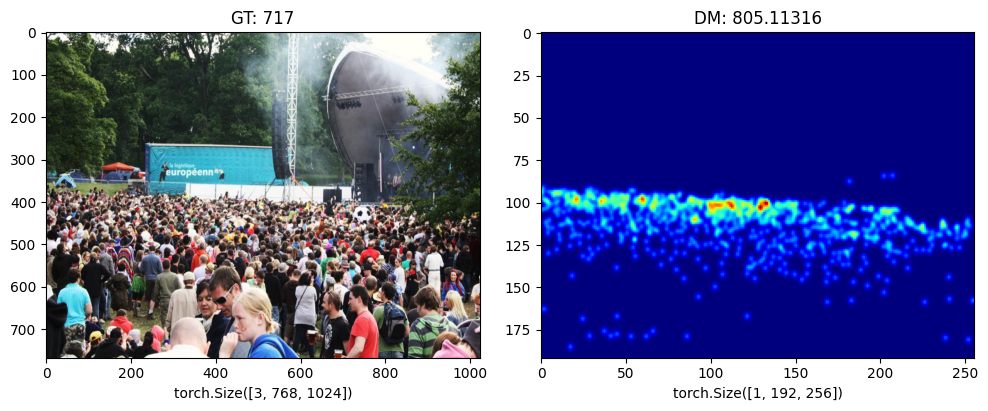

In [ ]:


# ──────────────────────────────────────────────────────────────────────────────
# 2) 데이터셋에서 하나씩 꺼내어 시각화
#    enumerate(dataset): (인덱스 i, (img, gt_dmap, n_people)) 튜플 생성
#    - img       : (3, H, W) 형태의 이미지 텐서 (0~1 스케일)
#    - gt_dmap   : (1, H/4, W/4) 형태의 density map 텐서
#    - n_people  : 해당 이미지에 있는 실제 사람 수(정수)
# ──────────────────────────────────────────────────────────────────────────────
for i, (img, gt_dmap, n_people) in enumerate(full_test):
    # ──────────────────────────────────────────────────────────────────────────
    # 2-1) 새 Figure(그림판) 생성
    #      figsize=(10,5): 가로 10인치, 세로 5인치 크기 지정
    # ──────────────────────────────────────────────────────────────────────────
    plt.figure(figsize=(10, 5))

    # ──────────────────────────────────────────────────────────────────────────
    # 2-2) 왼쪽 서브플롯: 원본 이미지
    # ──────────────────────────────────────────────────────────────────────────
    plt.subplot(1, 2, 1)                    # 1행 2열 중 첫 번째 칸
    plt.xlabel(img.shape)                   # x축 레이블에 텐서 모양 표시 (채널, 높이, 너비)
    plt.title('GT: ' + str(n_people))       # 제목에 실제 사람 수 표시
    # permute(1,2,0): (C,H,W) → (H,W,C)로 차원 순서 변경하여 imshow에 맞춤
    plt.imshow(img.permute(1, 2, 0))

    # ──────────────────────────────────────────────────────────────────────────
    # 2-3) 오른쪽 서브플롯: Density Map
    # ──────────────────────────────────────────────────────────────────────────
    plt.subplot(1, 2, 2)                    # 1행 2열 중 두 번째 칸
    plt.xlabel(gt_dmap.shape)               # x축 레이블에 density map 모양 표시 (1, H', W')
    # np.sum(gt_dmap.numpy()): density map 픽셀 값의 합 = 예측된 사람 수
    plt.title('DM: ' + str(np.sum(gt_dmap.numpy())))
    # permute(1,2,0): (1,H',W') → (H',W',1) → imshow가 (H',W')로 처리
    plt.imshow(gt_dmap.permute(1, 2, 0), cmap="jet")  # 'jet' 컬러맵으로 시각화

    # ──────────────────────────────────────────────────────────────────────────
    # 2-4) 화면에 출력
    # ──────────────────────────────────────────────────────────────────────────
    plt.tight_layout()  # 서브플롯 간 간격 자동 조정
    plt.show()

    # ──────────────────────────────────────────────────────────────────────────
    # 2-5) 첫 번째 이미지만 보고 루프 종료
    #      if i > 0: 조건을 통해 두 번째 반복 후 break
    #      → 디버깅용으로 한두 개만 확인할 때 사용
    # ──────────────────────────────────────────────────────────────────────────
    if i > 0:
        break


In [ ]:
class MC_CNN(nn.Module):
    """
    MC-CNN (Multi-Column Convolutional Neural Network) 모델 클래스
    - 서로 다른 커널 크기를 갖는 3개의 병렬 컬럼(column1, column2, column3)으로 특징을 추출
    - 마지막에 1×1 컨볼루션으로 세 컬럼의 채널을 합쳐 density map을 출력
    """
    def __init__(self):
        super().__init__()

        # ───────────────────────────────────────────────────────────────
        # column1: 큰 커널(9×9, 7×7) 위주로 넓은 수용 영역을 처리
        # ───────────────────────────────────────────────────────────────
        self.column1 = nn.Sequential(
            # 입력 채널 3(RGB), 출력 채널 8, 커널 크기 9, padding='same'으로 출력 크기 유지
            nn.Conv2d(3, 8, 9, padding='same'),
            nn.ReLU(),                   # 비선형 활성화
            nn.MaxPool2d(2),            # 2×2 맥스 풀링 → 해상도 절반으로 축소

            # 채널 8 → 16, 커널 7×7
            nn.Conv2d(8, 16, 7, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),            # 추가 풀링

            # 채널 16 → 32, 커널 7×7
            nn.Conv2d(16, 32, 7, padding='same'),
            nn.ReLU(),

            # 채널 32 → 16, 커널 7×7
            nn.Conv2d(32, 16, 7, padding='same'),
            nn.ReLU(),

            # 채널 16 → 8, 커널 7×7
            nn.Conv2d(16, 8, 7, padding='same'),
            nn.ReLU(),
        )

        # ───────────────────────────────────────────────────────────────
        # column2: 중간 커널(7×7, 5×5)으로 중간 규모의 특징 처리
        # ───────────────────────────────────────────────────────────────
        self.column2 = nn.Sequential(
            nn.Conv2d(3, 10, 7, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(10, 20, 5, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(20, 40, 5, padding='same'),
            nn.ReLU(),

            nn.Conv2d(40, 20, 5, padding='same'),
            nn.ReLU(),

            nn.Conv2d(20, 10, 5, padding='same'),
            nn.ReLU(),
        )

        # ───────────────────────────────────────────────────────────────
        # column3: 작은 커널(5×5, 3×3)으로 세밀한 로컬 특징 처리
        # ───────────────────────────────────────────────────────────────
        self.column3 = nn.Sequential(
            nn.Conv2d(3, 12, 5, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(12, 24, 3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(24, 48, 3, padding='same'),
            nn.ReLU(),

            nn.Conv2d(48, 24, 3, padding='same'),
            nn.ReLU(),

            nn.Conv2d(24, 12, 3, padding='same'),
            nn.ReLU(),
        )

        # ───────────────────────────────────────────────────────────────
        # fusion_layer: 세 컬럼의 출력을 채널 차원에서 이어붙인 후
        #               1×1 컨볼루션으로 채널 수를 1로 축소 → density map
        # ───────────────────────────────────────────────────────────────
        self.fusion_layer = nn.Sequential(
            # 입력 채널 30 = column1(8) + column2(10) + column3(12)
            # 출력 채널 1, 커널 1×1, padding=0
            nn.Conv2d(30, 1, 1, padding=0),
            # density map이므로 추가 활성화 함수는 보통 사용하지 않음
        )

    def forward(self, img_tensor):
        """
        순전파 실행 함수
        - img_tensor: (batch_size, 3, H, W) 형태의 입력 이미지 배치
        - 반환: (batch_size, 1, H', W') 형태의 density map 예측값
        """
        # 각 컬럼별로 병렬 처리
        x1 = self.column1(img_tensor)  # 큰 스케일 특징
        x2 = self.column2(img_tensor)  # 중간 스케일 특징
        x3 = self.column3(img_tensor)  # 작은 스케일 특징

        # 채널 차원(dim=1)에서 3개 결과를 이어붙임
        x = torch.cat((x1, x2, x3), dim=1)

        # 1×1 컨볼루션으로 채널 수 30 → 1로 축소
        x = self.fusion_layer(x)
        return x


In [ ]:
# ---------------------------------------------
# 1) 임의의 입력 텐서 생성 및 모델 출력 형태 확인
#    · torch.rand((1,3,768,1024)): 배치 크기 1, 채널 3, 높이 768, 너비 1024인 랜덤 텐서
#    · mcnn(img): MC_CNN 모델에 입력하여 출력 디멘션 확인
# ---------------------------------------------
img = torch.rand((1, 3, 768, 1024), dtype=torch.float)
mcnn = MC_CNN()            # MC_CNN 모델 인스턴스 생성
out_dmap = mcnn(img)       # 순전파 실행
print(out_dmap.shape)      # 예) torch.Size([1, 1, 192, 256]) → (배치, 채널, H/4, W/4)


torch.Size([1, 1, 192, 256])


In [ ]:

# ---------------------------------------------
# 2) 학습/검증/테스트용 DataLoader 준비
# ---------------------------------------------

batch_size = 8
# GPU 사용 가능 시 'cuda:0', 아니면 CPU 사용
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# 2-1) 전체 학습 데이터셋 로드
from torch.utils.data import ConcatDataset

# ─────────────────────────────────────────────────────────────────────────────
# 1) Part A, Part B 각각 Dataset 인스턴스 생성
# ─────────────────────────────────────────────────────────────────────────────
root = "/kaggle/input/shanghaitech/ShanghaiTech"

dsA = DataLoader(
    root_dir=os.path.join(root, 'part_A', 'train_data'),
    gt_downsample=4,
    shuffle=True
)
dsB = DataLoader(
    root_dir=os.path.join(root, 'part_B', 'train_data'),
    gt_downsample=4,
    shuffle=True
)

# ─────────────────────────────────────────────────────────────────────────────
# 2) 두 Dataset 합치기 (ConcatDataset)
# ─────────────────────────────────────────────────────────────────────────────
full_train = ConcatDataset([dsA, dsB])

# ─────────────────────────────────────────────────────────────────────────────
# 3) train/val 90:10 split
# ─────────────────────────────────────────────────────────────────────────────
total = len(full_train)
n_train = int(0.9 * total)
n_val   = total - n_train

train_dataset = torch.utils.data.Subset(full_train, list(range(n_train)))
val_dataset   = torch.utils.data.Subset(full_train, list(range(n_train, total)))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)


# 2-3) 테스트 데이터셋 로드 (셔플 없이 전체 사용)
test_root_dir = "/kaggle/input/shanghaitech/ShanghaiTech/part_B/test_data/"
test_set = DataLoader(
    root_dir=test_root_dir,
    gt_downsample=4,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False
)

# ---------------------------------------------
# 3) 각 DataLoader의 배치 개수 출력
#    · len(train_loader): 학습용 배치 수
#    · len(val_loader): 검증용 배치 수
#    · len(test_loader): 테스트용 배치 수
# ---------------------------------------------
print("Number of batches in train_loader:", len(train_loader))
print("Number of batches in val_loader:  ", len(val_loader))
print("Number of batches in test_loader: ", len(test_loader))


Number of batches in train_loader: 79
Number of batches in val_loader:   9
Number of batches in test_loader:  40


In [ ]:
def plot_corresponding_pairs(batch1, batch2, plot_map='jet'):
    """
    이미지 배치(batch1)와 대응하는 density map 배치(batch2)를
    그리드 형태로 한눈에 시각화하는 함수입니다.

    Parameters
    ----------
    batch1 : torch.Tensor
        (N, 3, H, W) 형태의 이미지 배치 텐서
    batch2 : torch.Tensor
        (N, 1, H', W') 형태의 density map 배치 텐서
    plot_map : str, optional
        density map 시각화에 사용할 컬러맵, 기본값은 'jet'
    """

    # 1) 배치 크기(N) 확인
    num_images = batch1.shape[0]  # 예: batch1.shape == (8,3,256,256) 이면 N=8

    # 2) 화면에 표시할 서브플롯(axes) 생성
    #    - num_rows: ceil(N/2) 행
    #    - num_cols: 4 열
    #    → 각 이미지와 density map이 2행 블록으로 붙어서 표시됨
    fig, axes = plt.subplots(int(np.ceil(num_images / 2)), 4)

    # 3) 배치 내 각 인덱스 i에 대해
    for i in range(num_images):
        # a) 원본 이미지 그리기
        #    - axes[row, col] 위치 계산:
        #      row = (i // 4) * 2, col = i % 4
        img_ax = axes[int(i / 4) * 2, i % 4]
        #    - batch1[i]: (3, H, W) → permute로 (H, W, 3) 형태로 변경
        img_ax.imshow(batch1[i].permute(1, 2, 0))
        img_ax.axis('off')  # 축(눈금/테두리) 숨기기

        # b) 대응하는 density map 그리기
        #    - 아래 행(row+1)에 배치
        dm_ax = axes[int(i / 4) * 2 + 1, i % 4]
        #    - batch2[i]: (1, H', W') → squeeze로 (H', W') 배열로 변환
        #    - detach().numpy(): GPU→CPU로 텐서 분리 후 NumPy 배열로 변환
        dm_ax.imshow(batch2[i].squeeze().detach().numpy(), cmap=plot_map)
        dm_ax.axis('off')  # 축 숨기기

        # c) density map 합계(예측 인원수)를 제목으로 표시
        pred_count = np.sum(batch2[i].detach().numpy())
        dm_ax.set_title('DM: ' + str(pred_count))

    # 4) 서브플롯 간 간격 자동 조정 후 화면에 표시
    plt.tight_layout()
    plt.show()

In [ ]:
#from torch.utils.data import ConcatDataset, DataLoader as TorchDL

#test_loader = TorchDL(full_test, batch_size=1, shuffle=False, num_workers=2)
# 1) train_loader에서 배치 단위로 데이터를 꺼내기 위한 이터레이터 생성
#dataiter = iter(train_loader)

# 2) 이터레이터에서 첫 번째 배치 가져오기
#    - ex_images   : (batch_size, 3, H, W) 형태의 이미지 텐서
#    - ex_dmaps    : (batch_size, 1, H', W') 형태의 density map 텐서
#    - ex_n_people : 각 이미지의 실제 사람 수가 담긴 리스트(또는 텐서)
#ex_images, ex_dmaps, ex_n_people = next(test_loader)
#for img, dmap, cnt in test_loader:
##   plot_corresponding_pairs(img, dmap)
  #  break


# 3) 시각화 함수 호출
#    - ex_images와 ex_dmaps를 한눈에 비교할 수 있도록 그리드로 보여줌
#plot_corresponding_pairs(ex_images, ex_dmaps)


# 4) 실제 사람 수(Ground Truth) 출력
#    - 리스트 내 각 요소(ex_n_people[j])를 .item()으로 스칼라로 변환
#    - '%5s' 포맷으로 고정 폭 필드(5칸)에 맞춰 문자열로 변환
#    - ' '.join(...) 으로 배치 크기만큼 공백으로 구분해 한 줄로 출력
#print(' '.join('%5s' % ex_n_people[j].item() for j in range(batch_size)))

In [ ]:
class CombinedLoss(nn.Module):
    """
    결합 손실 함수 클래스
    - 밀도 맵 예측 오차(MSE)와 예측 인원수 오차(MAE)를 가중합하여
      모델 학습 시 두 목표를 동시에 최적화할 수 있도록 합니다.
    """

    def __init__(self, weight_dmap=0.8, weight_sum_gt=0.2):
        super().__init__()
        # 1) 밀도 맵 손실과 인원수 손실의 가중치
        self.weight_dmap   = weight_dmap   # 밀도 맵 MSE 손실 가중치
        self.weight_sum_gt = weight_sum_gt # 인원수 MAE 손실 가중치

        # 2) 내부적으로 사용할 개별 손실 함수들
        self.img_loss     = nn.MSELoss()  # 밀도 맵 간 픽셀 단위 MSE
        self.gt_loss_mse  = nn.MSELoss()  # 예측 인원수 vs GT 인원수 MSE
        self.gt_loss_mae  = nn.L1Loss()   # 예측 인원수 vs GT 인원수 MAE

    def forward(self, logits, batch_dmap, batch_gts):
        """
        순전파 시 손실 계산
        Parameters
        ----------
        logits     : torch.Tensor, shape (N, 1, H', W')
                     모델이 예측한 density map
        batch_dmap : torch.Tensor, shape (N, 1, H', W')
                     정답 density map
        batch_gts  : torch.Tensor, shape (N,)
                     정답 사람 수(스칼라)

        Returns
        -------
        combined_loss : torch.Tensor
                        가중합된 최종 손실 값
        gt_loss_mae   : torch.Tensor
                        예측 인원수 MAE 손실 값 (모니터링용)
        """
        # 1) ground-truth 인원수 텐서를 float 타입으로 변환
        batch_gts = batch_gts.float()

        # 2) 밀도 맵 간 픽셀 단위 MSE 손실 계산
        #    logits와 batch_dmap 모두 (N,1,H',W') 형태
        img_loss = self.img_loss(logits, batch_dmap)

        # 3) 예측 density map을 합산하여 전체 인원수 예측 벡터 생성
        #    .sum(dim=(2,3)): H',W' 축을 합산 → (N,1) 텐서
        #    torch.squeeze(): 채널 차원 제거 → (N,) 벡터
        pred_counts = torch.squeeze(logits.sum(dim=(2,3)))

        # 4) 예측 인원수와 GT 인원수 간 MAE, MSE 손실 계산
        gt_loss_mae = self.gt_loss_mae(pred_counts, batch_gts)
        gt_loss_mse = self.gt_loss_mse(pred_counts, batch_gts)

        # 5) 최종 손실 = weight_dmap * img_loss + weight_sum_gt * gt_loss_mae
        combined_loss = self.weight_dmap * img_loss + self.weight_sum_gt * gt_loss_mae

        # 6) 반환: (통합 손실, MAE 손실)
        return combined_loss, gt_loss_mae

In [ ]:
# 총 학습 에폭 수 설정
num_epochs = 50

# 손실 및 MAE 기록용 리스트 초기화
train_losses = []       # 학습 손실 기록
val_losses = []         # 검증 손실 기록
train_mae_losses = []   # 학습 MAE 기록
val_mae_losses = []     # 검증 MAE 기록

# 모델과 손실 함수, 옵티마이저 초기화
model = MC_CNN().to(device)               # MC-CNN 모델을 GPU/CPU에 올림
criterion = CombinedLoss(0.8, 0.2)        # 밀도 맵 MSE 0.8, 인원수 MAE 0.2 가중합 손실
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Adam 옵티마이저, 학습률 1e-3

# 최적의 검증 손실과 에폭 인덱스 초기화
best_val_loss = np.inf    # 매우 큰 값으로 시작
best_nr_epoch = 0

# ─────────────────────────────────────────────────────────────────────────────
# 에폭 루프: 0부터 num_epochs-1 까지
# ─────────────────────────────────────────────────────────────────────────────
for epoch in range(num_epochs):
    print(f"Epoch {epoch}:")

    # ----- 학습 단계 -----
    tr_loss_acc = 0.0      # 에폭당 누적 손실 합계
    tr_loss_mae_acc = 0.0  # 에폭당 누적 MAE 합계

    for batch_img, batch_dmap, batch_gts in train_loader:
        # 1) 배치 데이터를 GPU/CPU로 이동
        batch_img, batch_dmap, batch_gts = (
            batch_img.to(device),
            batch_dmap.to(device),
            batch_gts.to(device)
        )

        # 2) 모델 순전파 & 손실 계산
        logits = model(batch_img)
        loss, mae_loss = criterion(logits, batch_dmap, batch_gts)

        # 3) 역전파 및 파라미터 업데이트
        optimizer.zero_grad()  # 기울기 초기화
        loss.backward()        # 역전파
        optimizer.step()       # 가중치 갱신

        # 4) 누적 손실 값 업데이트
        tr_loss_acc     += loss.item()      # MSE+MAE 가중합 손실 누적
        tr_loss_mae_acc += mae_loss.item()  # MAE 손실 누적

    # 평균 손실 계산 (샘플 수로 나누어 한 이미지당 손실)
    tr_loss = tr_loss_acc / len(train_loader.dataset)
    tr_mae  = tr_loss_mae_acc / len(train_loader.dataset)

    print(f">> TRAIN: Epoch {epoch} | tr_loss:  {tr_loss:.6f}")
    print(f">> TRAIN: Epoch {epoch} | mae:      {tr_mae:.6f}")

    # ----- 검증 단계 -----
    with torch.inference_mode():  # no_grad()와 비슷하게 그래디언트 비활성
        val_loss_acc     = 0.0
        val_loss_mae_acc = 0.0

        for batch_img_val, batch_dmap_val, batch_gts_val in val_loader:
            # 1) 검증 배치 데이터를 디바이스로 이동
            batch_img_val, batch_dmap_val, batch_gts_val = (
                batch_img_val.to(device),
                batch_dmap_val.to(device),
                batch_gts_val.to(device)
            )

            # 2) 순전파 & 손실 계산
            logits, _ = model(batch_img_val), None  # 모델 출력
            loss, mae_loss = criterion(logits, batch_dmap_val, batch_gts_val)

            # 3) 누적 검증 손실 업데이트
            val_loss_acc     += loss.item()
            val_loss_mae_acc += mae_loss.item()

    # 평균 검증 손실 계산
    val_loss = val_loss_acc / len(val_loader.dataset)
    val_mae  = val_loss_mae_acc / len(val_loader.dataset)

    print(f">> VAL:   Epoch {epoch} | val_loss: {val_loss:.6f}")
    print(f">> VAL:   Epoch {epoch} | mae:      {val_mae:.6f}")

    # ----- 최적 모델 저장 -----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_nr_epoch = epoch
        # 검증 손실이 가장 낮은 모델 파라미터 저장
        torch.save(model.state_dict(), './crowd_counting.pth')

    # 손실 기록 리스트에 추가
    train_losses.append(tr_loss)
    train_mae_losses.append(tr_mae)
    val_losses.append(val_loss)
    val_mae_losses.append(val_mae)

# ─────────────────────────────────────────────────────────────────────────────
# 최적 에폭에서의 MAE 결과 출력
# ─────────────────────────────────────────────────────────────────────────────
print('best training MAE: ', train_mae_losses[best_nr_epoch])
print('best val MAE:      ', val_mae_losses[best_nr_epoch])

Epoch 0:
>> TRAIN: Epoch 0 | tr_loss:  19.316244
>> TRAIN: Epoch 0 | mae:      96.580146
>> VAL:   Epoch 0 | val_loss: 3.550402
>> VAL:   Epoch 0 | mae:      17.751899
Epoch 1:
>> TRAIN: Epoch 1 | tr_loss:  5.670803
>> TRAIN: Epoch 1 | mae:      28.353437
>> VAL:   Epoch 1 | val_loss: 1.758169
>> VAL:   Epoch 1 | mae:      8.790743
Epoch 2:
>> TRAIN: Epoch 2 | tr_loss:  5.192678
>> TRAIN: Epoch 2 | mae:      25.962824
>> VAL:   Epoch 2 | val_loss: 1.799675
>> VAL:   Epoch 2 | mae:      8.998273
Epoch 3:
>> TRAIN: Epoch 3 | tr_loss:  5.031525
>> TRAIN: Epoch 3 | mae:      25.157067
>> VAL:   Epoch 3 | val_loss: 2.099953
>> VAL:   Epoch 3 | mae:      10.499661
Epoch 4:
>> TRAIN: Epoch 4 | tr_loss:  5.929870
>> TRAIN: Epoch 4 | mae:      29.648791
>> VAL:   Epoch 4 | val_loss: 1.803847
>> VAL:   Epoch 4 | mae:      9.019135
Epoch 5:
>> TRAIN: Epoch 5 | tr_loss:  5.475638
>> TRAIN: Epoch 5 | mae:      27.377639
>> VAL:   Epoch 5 | val_loss: 4.460465
>> VAL:   Epoch 5 | mae:      22.302219


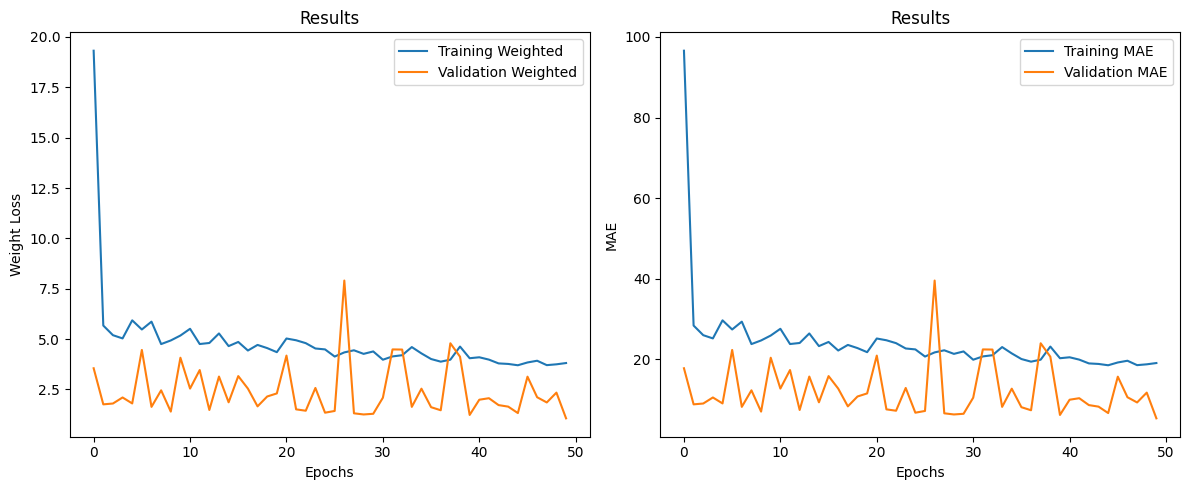

In [ ]:
# 전체 학습/검증 손실 및 MAE 변화를 2열 서브플롯으로 시각화
plt.figure(figsize=(12, 5))  # 전체 Figure 크기 설정 (가로 12인치, 세로 5인치)

# ────────────────────────────────────────────────────────────
# 1) 왼쪽 서브플롯: 가중 손실(Training Weighted vs Validation Weighted)
# ────────────────────────────────────────────────────────────
plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째 칸 선택
plt.plot(train_losses, label='Training Weighted')    # 학습 손실 곡선
plt.plot(val_losses,   label='Validation Weighted')  # 검증 손실 곡선
plt.title('Results')       # 서브플롯 제목 설정
plt.ylabel('Weight Loss')  # y축 레이블 설정
plt.xlabel('Epochs')       # x축 레이블 설정
plt.legend()               # 범례 표시

# ────────────────────────────────────────────────────────────
# 2) 오른쪽 서브플롯: MAE(Training MAE vs Validation MAE)
# ────────────────────────────────────────────────────────────
plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째 칸 선택
plt.plot(train_mae_losses, label='Training MAE')       # 학습 MAE 곡선
plt.plot(val_mae_losses,   label='Validation MAE')     # 검증 MAE 곡선
plt.title('Results')        # 서브플롯 제목 설정
plt.ylabel('MAE')           # y축 레이블 설정
plt.xlabel('Epochs')        # x축 레이블 설정
plt.legend()                # 범례 표시

# ────────────────────────────────────────────────────────────
# 3) 레이아웃 조정 및 출력
# ────────────────────────────────────────────────────────────
plt.tight_layout()  # 서브플롯 간 간격 자동 조정 (중첩 방지)
plt.show()          # Figure를 화면에 렌더링

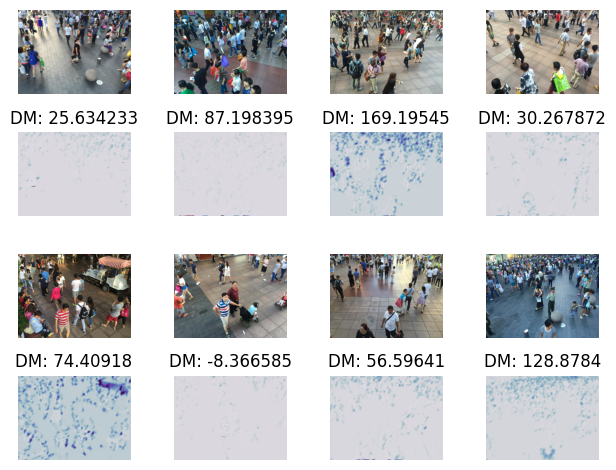

   78    87   175    26    47    12    86   521


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 1) 최적 모델 인스턴스 생성 및 저장된 파라미터 로드
#    - MC_CNN 클래스 기반 모델을 device(GPU/CPU)에 올리고,
#      torch.load로 저장된 상태 사전(state_dict)을 불러와 가중치 설정
# ─────────────────────────────────────────────────────────────────────────────
best_model = MC_CNN().to(device)
best_model.load_state_dict(torch.load('./crowd_counting.pth'))
best_model.eval()  # 평가 모드로 전환 (BatchNorm/Dropout 비활성)

# ─────────────────────────────────────────────────────────────────────────────
# 2) 검증 데이터 중 무작위로 한 배치 가져오기
#    - val_loader는 이미 Subset으로 분할되어 셔플=False 설정된 검증 DataLoader
#    - iter()로 이터레이터 생성한 뒤 next()로 첫 번째 배치 취득
#    - 반환값: (ex_images, ex_dmaps_unused, ex_gts)
#      · ex_images : (batch_size, 3, H, W) 이미지 텐서
#      · ex_dmaps_unused: density map 텐서 (여기서는 사용하지 않으므로 _ 처리)
#      · ex_gts    : 각 이미지의 실제 사람 수 스칼라 텐서
# ─────────────────────────────────────────────────────────────────────────────
dataiter = iter(val_loader)
ex_images, _, ex_gts = next(dataiter)

# ─────────────────────────────────────────────────────────────────────────────
# 3) 예측 수행
#    - ex_images.to(device): 모델 입력을 위해 GPU/CPU에 이미지 배치 복사
#    - best_model(...) 호출이 순전파(Forward Propagation) 실행
#    - pred_dms: (batch_size, 1, H', W') 형태의 예측 density map 텐서
# ─────────────────────────────────────────────────────────────────────────────
pred_dms = best_model(ex_images.to(device))

# ─────────────────────────────────────────────────────────────────────────────
# 4) 시각화
#    - plot_corresponding_pairs 함수 사용
#    - ex_images.cpu(): 시각화를 위해 CPU로 텐서 복귀 후
#      .cpu()→.numpy() 내부 변환을 통해 matplotlib에 표시
#    - pred_dms.cpu(): 예측 density map도 동일하게 CPU 복귀
#    - 'twilight' 컬러맵으로 density map 강조
# ─────────────────────────────────────────────────────────────────────────────
plot_corresponding_pairs(ex_images.cpu(), pred_dms.cpu(), 'twilight')

# ─────────────────────────────────────────────────────────────────────────────
# 5) 실제 정답(레이블) 출력
#    - ex_gts[j].item(): 각 텐서 요소를 Python int로 변환
#    - '%5s' 포맷: 5칸 고정 폭 문자열로 정리
#    - ' '.join: 배치 크기만큼 공백으로 구분된 한 줄 출력
# ─────────────────────────────────────────────────────────────────────────────
print(' '.join('%5s' % ex_gts[j].item() for j in range(batch_size)))

In [ ]:
best_model = MC_CNN().to(device)
# MC_CNN 모델 인스턴스를 생성하여 GPU/CPU(device)에 올립니다.

best_model.load_state_dict(torch.load('./crowd_counting.pth'))
# 이전에 저장한 최적 모델 파라미터(crowd_counting.pth)를 로드하여 모델에 적용합니다.

criterion = nn.L1Loss()
# 테스트 단계에서는 MAE(Mean Absolute Error)를 평가 지표로 사용하기 위해 L1 손실 함수를 정의합니다.

test_loss_acc = 0.0
# 전체 테스트 데이터셋에 대한 MAE 누적 합계를 저장할 변수 초기화

with torch.inference_mode():
    # torch.no_grad()와 유사하게 그래디언트 계산을 비활성화하여 메모리 사용량과 연산 속도를 최적화합니다.
    for batch_img, batch_dmap, batch_gts in test_loader:
        # 1) 테스트 배치 데이터를 device(GPU/CPU)로 복사
        batch_img, batch_dmap, batch_gts = (
            batch_img.to(device),
            batch_dmap.to(device),
            batch_gts.to(device)
        )

        # 2) 모델 순전파 수행: 예측된 density map(logits) 반환
        logits = best_model(batch_img)

        # 3) 예측 인원수 계산:
        #    logits.sum(dim=(2,3)): 각 density map 픽셀을 모두 합산 → (N, 1) 텐서
        #    torch.squeeze(...): 채널 차원 제거 → (N,) 벡터
        pred_counts = torch.squeeze(logits.sum(dim=(2,3)))

        # 4) MAE 계산: 예측 인원수(pred_counts)와 실제 인원수(batch_gts) 간 절댓값 오차
        loss = criterion(pred_counts, batch_gts)

        # 5) 누적 MAE 합계 갱신
        test_loss_acc += loss.item()

# 6) 최종 테스트 MAE 출력:
#    전체 샘플 수(len(test_loader.dataset))로 나누어 한 이미지당 평균 MAE 계산
print('TEST:  test_MAE: {:.3f}'.format(test_loss_acc / len(test_loader.dataset)))

TEST:  test_MAE: 6.319


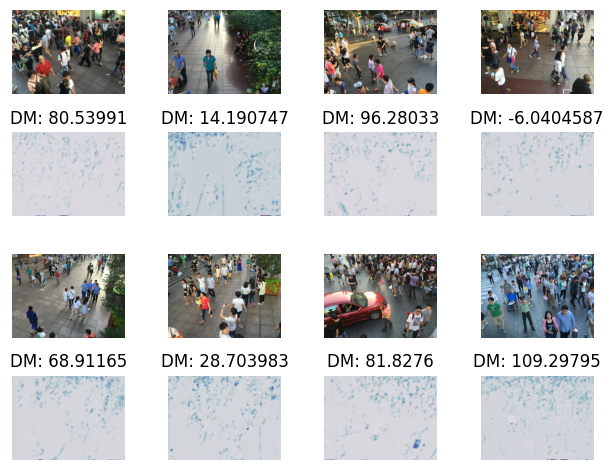

  117    29    89    45    73    47    90   170


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 1) 테스트 데이터 로더에서 무작위 배치 하나 가져오기
#    - test_loader: 배치 단위로 (이미지 텐서, density map, 정답 인원수) 반환
#    - iter(test_loader): 이터레이터 생성
#    - next(dataiter): 첫 번째 배치 튜플 얻기
#      · ex_images : (batch_size, 3, H, W) 이미지 텐서
#      · _         : density map 텐서 (여기서는 사용하지 않으므로 언더바로 무시)
#      · ex_gts    : 각 이미지의 실제 사람 수 텐서
# ─────────────────────────────────────────────────────────────────────────────
dataiter = iter(test_loader)
ex_images, _, ex_gts = next(dataiter)


# ─────────────────────────────────────────────────────────────────────────────
# 2) 모델에 이미지 배치를 입력하여 예측된 density map 계산
#    - ex_images.to(device): GPU/CPU(device)로 텐서 복사
#    - best_model(...): 순전파(Forward Propagation) 실행
#    - pred_dms: (batch_size, 1, H', W') 형태의 예측 결과
# ─────────────────────────────────────────────────────────────────────────────
pred_dms = best_model(ex_images.to(device))


# ─────────────────────────────────────────────────────────────────────────────
# 3) 예측된 density map과 원본 이미지를 함께 시각화
#    - ex_images.cpu(): 시각화 전 CPU로 텐서 복귀
#    - pred_dms.cpu(): 예측 결과도 CPU로 이동
#    - 'twilight' 컬러맵 사용하여 density map 강조
# ─────────────────────────────────────────────────────────────────────────────
plot_corresponding_pairs(ex_images.cpu(), pred_dms.cpu(), 'twilight')


# ─────────────────────────────────────────────────────────────────────────────
# 4) 정답 사람 수(Ground Truth)를 한 줄로 출력
#    - ex_gts[j].item(): 텐서 요소를 Python int로 변환
#    - '%5s' % ...: 5칸 폭 문자열 포맷
#    - ' '.join(...): 배치 크기만큼 공백으로 구분해 한 줄에 나열
# ─────────────────────────────────────────────────────────────────────────────
print(' '.join('%5s' % ex_gts[j].item() for j in range(batch_size)))

In [ ]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def alert_on_image(
    image_path: str,
    pixels_per_meter: float,
    caution_density: float = 2.0,
    danger_density:  float = 4.0,
    model: torch.nn.Module = None,
    device: str = 'cpu'
):
    """
    이미지 경로와 픽셀→미터 환산값을 받아
    1) density map 시각화
    2) 면적당 인구밀도 계산 & 경고 레벨 표시
    3) 경고 오버레이 이미지 반환
    """
    # 1) 이미지 로드
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise FileNotFoundError(f"이미지를 찾을 수 없습니다: {image_path}")
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    H, W    = img_rgb.shape[:2]

    # 2) MC-CNN 순전파로 density map 얻기
    inp = torch.tensor(
        img_rgb.transpose(2,0,1)[None] / 255.0,
        dtype=torch.float, device=device
    )
    with torch.no_grad():
        dmap = model(inp)[0,0]   # (H/4, W/4) 형태
    dmap_np = dmap.cpu().numpy()


    # 3) density map 시각화
    plt.figure(figsize=(6,6))
    plt.title("Predicted Density Map")
    plt.imshow(dmap_np, cmap='jet')
    plt.colorbar(label='Density')
    plt.axis('off')
    print("image_size",H,W)
    plt.show()

    # 4) Count, 면적, 밀도 계산
    pred_count = dmap_np.sum()
    area_m2    = (W / pixels_per_meter) * (H / pixels_per_meter)
    density    = pred_count / area_m2

    # 5) 경고 레벨 결정
    if density >= danger_density:
        level = '🚨 DANGER'
    elif density >= caution_density:
        level = '⚠️ CAUTION'
    else:
        level = '✅ SAFE'

    # 6) 결과 출력
    print(f"[{level}] Count={pred_count:.1f}, "
          f"Area={area_m2:.2f}㎡, Density={density:.2f} ppl/㎡")

    # 7) 오버레이 배너 그리기
    banner = img_bgr.copy()
    color_map = {
        '✅ SAFE':    (0,255,0),
        '⚠️ CAUTION': (0,165,255),
        '🚨 DANGER':  (0,0,255)
    }
    cv2.rectangle(banner, (0,0), (W,40), color_map[level], -1)
    overlay = cv2.addWeighted(banner, 0.6, img_bgr, 0.4, 0)
    cv2.putText(
        overlay,
        f"{level}  Count={pred_count:.1f}, Density={density:.2f} ppl/㎡",
        (10,25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2
    )

    return overlay

# --- 특정 이미지 선택 & 실행 예시 ---
selected_image = '/kaggle/input/shanghaitech/ShanghaiTech/part_A/test_data/images/IMG_10.jpg'
path_gt_ex = "/kaggle/input/shanghaitech/ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_10.mat"
gt_ex = loadmat(path_gt_ex)
gt_coor_ex = gt_ex.get('image_info')[0][0][0][0][0]
overlay_img = alert_on_image(
    image_path=selected_image,
    pixels_per_meter=100.0,       # 사용자 제공 값
    caution_density=2.0,
    danger_density=4.0,
    model=best_model,
    device=device
)

# --- overlay 시각화 ---
plt.figure(figsize=(6,6))
plt.title('GT: ' + str(gt_coor_ex.shape[0]))
#plt.title('test image')
plt.imshow(cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

NameError: name 'loadmat' is not defined